- 事故種別(基本)名について
  "医師搬送"は除外しても良さそう(医師を運んだだけ？、傷病名の記載もない)
  "転院搬送"も関係なさそう

- 収容機関名
  "不搬送"はいらないのでは？
  →不搬送を除外すると、傷病名が空欄は無くなったし、事故種別の医師搬送もなくなった

- 傷病名(大, 中, 小)分類(国)名
  一旦いらないかな

In [ ]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(''), '../src/'))
import pandas as pd

def clean_data(df):
    # 次の列の種類をstringに変更する: '覚知日付(元号年月日)'
    df = df.astype({'覚知日付(元号年月日)': 'string'})
    df = df.astype({'覚知日付(元号)名': 'string'})
    df = df.astype({'覚知日付(年)': 'string'})
    df = df.astype({'覚知日付(月)': 'string'})
    df = df.astype({'覚知日付(日)': 'string'})
    df = df.astype({'覚知時刻(時)': 'string'})
    df = df.astype({'覚知時刻(分)': 'string'})

    df["datestr"] = df["覚知日付(元号)名"] + df["覚知日付(年)"] +"年" + df["覚知日付(月)"] +"月"+ df["覚知日付(日)"]+"日" \
                    + " " + df["覚知時刻(時)"] + ":" + df["覚知時刻(分)"]
    df.drop(['覚知日付(元号年月日)','覚知日付(元号)名','覚知日付(年)',
             '覚知日付(月)','覚知日付(日)','覚知時刻(時)','覚知時刻(分)'],axis=1,inplace=True)
    import jp_datetime
    df["datetime"] = df["datestr"].apply(lambda x: 
                                         jp_datetime.parse_date(x,'%g%e年%m月%d日 %H:%M')
                                         )
    df.drop(['datestr'],axis=1,inplace=True)
    df = df.reindex(['datetime','出場隊名', '事故種別(基本)名', '覚知→現着(所要時間)', '覚知→病着(所要時間)', '年齢(歳)', '年齢区分名',
       '性別名', '傷病程度名', '傷病名', '傷病名大分類(国)名', '傷病名中分類(国)名', '傷病名小分類(国)名',
       '収容機関名', '行政区別区分名'], axis=1)
    

    # 病院に実際に来る場合を対象にしたいので、不搬送を除去
    df = df[df['収容機関名'] != "不搬送"]

    # 列を削除: '傷病名大分類(国)名'
    df = df.drop(columns=['傷病名大分類(国)名'])
    df = df.drop(columns=['傷病名中分類(国)名'])
    df = df.drop(columns=['傷病名小分類(国)名'])

    # count用に列を追加
    df["count"] = 1

    # 列で並べ替えます: 'datetime' (昇順)
    df = df.sort_values(['datetime'], ignore_index=True)
    
    return df

# excel形式のデータ読み込み
df = pd.concat(
    [pd.read_excel(r'../input/01_令和元年.xlsx'),
    pd.read_excel(r"../input/02_令和２年.xlsx"),
    pd.read_excel(r"../input/03_令和３年.xlsx"),
    pd.read_excel(r"../input/04_令和４年.xlsx"),
    pd.read_excel(r"../input/05_令和５年.xlsx")]
)
df_clean = clean_data(df.copy())
df_clean.head(3)
# df_clean.傷病名.to_csv("../output/傷病名一覧.csv",index=None)
# 保存
df_clean.to_pickle('../output/df_clean.pkl.gz', compression='gzip') # 圧縮有り

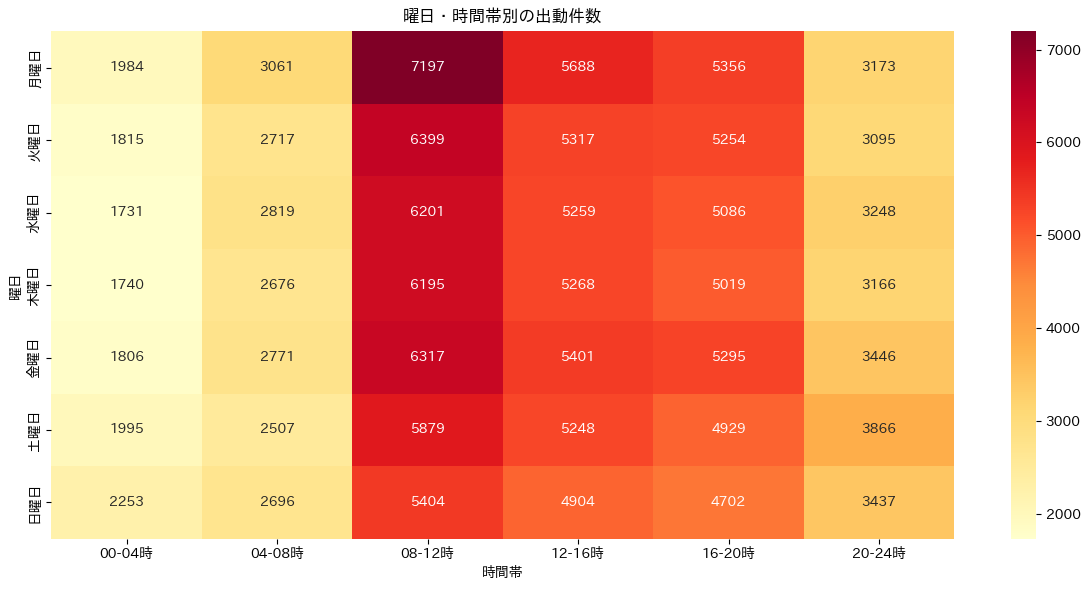


時間帯・曜日別の出動件数:
time_slot  00-04時  04-08時  08-12時  12-16時  16-20時  20-24時
weekday                                                  
月曜日          1984    3061    7197    5688    5356    3173
火曜日          1815    2717    6399    5317    5254    3095
水曜日          1731    2819    6201    5259    5086    3248
木曜日          1740    2676    6195    5268    5019    3166
金曜日          1806    2771    6317    5401    5295    3446
土曜日          1995    2507    5879    5248    4929    3866
日曜日          2253    2696    5404    4904    4702    3437


In [1]:
import os
import sys
import japanize_matplotlib
sys.path.append(os.path.join(os.path.abspath(''), '../src/'))
import pandas as pd
# 集計
df_clean = pd.read_pickle('../output/df_clean.pkl.gz', compression='gzip') # 圧縮有り
df_mod =  df_clean.copy()
df_mod.set_index(keys="datetime",inplace=True)
# 日付列から曜日を抽出
df_mod['weekday'] = df_mod.index.day_name()  # または .dt.weekday でも可
# 日本語の曜日表示にする場合
weekday_mapping = {
    'Monday': '月曜日',
    'Tuesday': '火曜日',
    'Wednesday': '水曜日',
    'Thursday': '木曜日',
    'Friday': '金曜日',
    'Saturday': '土曜日',
    'Sunday': '日曜日'
}
df_mod["weekday"] = df_mod["weekday"].map(weekday_mapping)

# 時間帯（4時間区切り）を作成
df_mod['time_slot'] = pd.to_datetime(df_mod.index).hour // 4
df_mod['time_slot'] = df_mod['time_slot'].map({
    0: '00-04時',
    1: '04-08時',
    2: '08-12時',
    3: '12-16時',
    4: '16-20時',
    5: '20-24時'
})
# 曜日と時間帯でグループ化して件数を集計
time_weekday_count = df_mod.groupby(['weekday', 'time_slot']).sum()["count"]

# ヒートマップ用のピボットテーブルを作成
pivot_counts = time_weekday_count.unstack()

# 曜日の順序を設定
weekday_order = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
pivot_counts = pivot_counts.reindex(weekday_order)

# ヒートマップの作成
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_counts, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('曜日・時間帯別の出動件数')
plt.ylabel('曜日')
plt.xlabel('時間帯')
plt.tight_layout()
plt.show()

# 集計結果を表示
print("\n時間帯・曜日別の出動件数:")
print(pivot_counts)

In [ ]:
import re
# float型の値を文字列に変換し、NANを適切に処理
def preprocess_disease_name(name):
    if pd.isna(name):
        return "不明"
    if isinstance(name, (int, float)):
        return str(int(name))
    return str(name)

df_categolized = df_clean.copy()
df_categolized['傷病名'] = df_categolized['傷病名'].apply(preprocess_disease_name)

# 傷病名の正規化関数
def simplify_disease_name(name):
    
    # 括弧内の詳細情報を除去
    name = re.sub(r'[\(（].*?[\)）]', '', name)
    # 疑いの表現を統一
    name = re.sub(r'(の疑い|疑い|疑|と思われる)', '疑い', name)
    return name.strip()

#疼痛について、運動器の痛みは整形外科にした
#外傷について、硬膜外血腫は神経に入れた
# 分類ルール
rules = {
    '外傷系': r'(咬傷|骨折|転倒|打撲|裂傷|挫傷|外傷|脱臼|擦過傷|刺傷|切創|挫創|熱傷|捻挫|脳震盪|心臓震盪|頸髄損傷|頚椎損傷|脊髄損傷|頸椎損傷|頭部血腫|圧挫症候群|腹腔内出血|血胸|デグロービング損傷|コンパートメント症候群|肝損傷)',
    '整形外科':r'(腰椎すべり症|椎間板ヘルニア|頸椎ヘルニア|腰椎ヘルニア|椎症|脊柱管狭窄症|坐骨神経痛|肋間神経痛|神経痛|肩痛|関節痛|膝部痛|膝痛|大腿部痛|下腿部痛|下肢痛|関節炎|関節症|腱断裂|靱帯損傷|リウマチ|半月板損傷)',
    '循環器系': r'(大動脈解離|大動脈瘤|大動脈瘤破裂|心筋梗塞|虚血性心疾患|急性冠症候群|不整脈|高血圧|狭心症|心不全|心筋症|心膜炎|血圧|房室ブロック|心房細動|心房粗動|心室頻拍|心室性頻拍|上室性頻拍|洞性頻脈|頻脈|上室頻拍|心室性期外収縮|肺血栓塞栓症|肺塞栓症|洞不全症候群|徐脈|弁狭窄|弁閉鎖不全|静脈血栓症|ＣｏｍｐｌｅｔｅＡＶｂｌｏｃｋ)',
    '脳神経系': r'(硬膜外血腫|脳卒中|脳梗塞|ラクナ梗塞|脳幹梗塞|急性期脳血栓症|脳塞栓症|脳幹出血|被殻出血|視床出血|皮質下出血|脳血管障害|脳動脈瘤|脳出血|もやもや病|くも膜下出血|脳腫瘍|水頭症|てんかん|痙攣|意識障害|頭痛|脳虚血|ＴＩＡ|パーキンソン|けいれん|構音障害|呂律障害|末梢神経障害|麻痺|痺れ|神経麻痺|歩行障害|筋萎縮性側索硬化症|多系統萎縮症|失調歩行)',
    '消化器系': r'(腹痛|胃炎|胆石|腸炎|下痢|嘔吐|消化管|吐血|下血|血便|急性腹症|腸|イレウス|胆管|胆嚢|胆のう|腹膜炎|憩室炎|虫垂炎|食道静脈瘤|マロリーワイス症候群|憩室出血|消化器出血|逆流性食道炎|胃潰瘍|急性胃粘膜病変|潰瘍性大腸炎|クローン|膵炎|肝硬変|肝障害|肝機能障害|閉塞性黄疸|肝性脳症|膵臓癌|膵癌|胃癌|胃がん|肝癌|肝臓癌|食道癌|食道ヘルニア|食道裂孔ヘルニア|裂孔ヘルニア|鼠経ヘルニア|鼠径ヘルニア|脱肛|肝臓癌|肝膿瘍|腹水)',
    '呼吸器系': r'(肺炎|気管支炎|喘息|呼吸困難|咳|痰|気道|過換気|肺癌|肺がん|慢性閉塞性肺疾患|気管支拡張症|間質性肺炎|肺線維症|ＣＯＰＤ|ＣＯ２ナルコーシス|肺気腫|気胸|胸膜炎|膿胸|肺化膿症|乳癌|縦隔気腫)',
    '血液内科': r'(リンパ腫|白血病|多発性骨髄腫|再生不良性貧血|特発性血小板減少性紫斑病|悪性リンパ腫|骨髄異形成症候群|骨髄線維症|骨髄腫|血小板減少|白血球減少|汎血球減少|血友病|溶血性貧血|ヘモグロビン低下|鉄欠乏性貧血|溶血|血栓性血小板減少性紫斑病)',
    '感染症': r'(感染症|敗血症|髄膜炎|発熱|熱発|インフルエンザ|咽頭炎|感冒|悪寒|蜂窩織炎|帯状疱疹|非結核性抗酸菌症|扁桃炎|扁桃周囲膿瘍|急性喉頭蓋炎|結核)',
    '代謝系': r'(糖尿病|電解質|脱水|低血糖|高血糖|痛風|偽痛風|低カリウム血症|高カリウム血症|低ナトリウム血症|高ナトリウム血症|高アンモニア血症|高カルシウム血症|低カルシウム血症)',
    '中毒': r'(中毒|過量摂取|アルコール|薬物)',
    '精神系': r'(統合失調|双極性障害|うつ病|不安|精神|認知症|心因反応|解離性障害|パニック障害|パニック発作|せん妄|うつ病|鬱病|不眠症|適応障害|解離性同一性障害|身体表現性障害|摂食障害|転換性障害|ヒステリー|レストレスレッグス|心臓神経症)',
    '産婦人科系': r'(分娩|妊娠|流産|性器出血|流産|早産|切迫流産|陣痛|切迫早産|生理痛|月経痛|月経困難症|破水|子宮筋腫|卵巣|子宮|不正出血|産後出血)',
    '小児科系': r'(熱性痙攣|百日咳|川崎病|クループ|臍ヘルニア)',
    '泌尿器系': r'(腎臓癌|腎癌|膀胱|尿|前立腺|排尿|水腎|腎盂腎炎|腎結石|腎障害|精巣捻転)',
    '耳鼻科系': r'(鼻出血|メニエール|末梢性眩暈|難聴|突発性難聴|耳鳴り|中耳炎|副鼻腔炎)',
    '老年' : r'(便秘|誤嚥|衰弱|体動困難|歩行困難|起立困難|老衰|褥瘡|廃用症候群)',
    '非特異的愁訴' : r'(喀血|嘔気|悪心|振戦|不随意運動|食欲不振|食思不振|貧血|黄疸|めまい|過呼吸|動悸|呼吸苦|気分不快|胸部不快|胸部違和感|胸部圧迫感|倦怠感|頭重感|自律神経失調症|ふらつき|全身の痛み|全身の震え|不定愁訴)',
    '心肺停止' : r'(心肺停止|ＣＰＡ|心停止)',
    '腎不全' : r'(腎不全)',
    '痛み' : r'(広背筋痛|下腹部痛|上腹部痛|胃痛|背部痛|心窩部痛|胸部痛|胸痛|後頸部痛|腰痛|腰部痛|殿部痛|頸部痛|季肋部痛|左側腹部痛|右側腹部痛|胸部絞扼感|後頭部痛|鼠径部痛|癌性疼痛)',
    '非外傷性救急' : r'(溺水|呼吸不全|窒息|異物|誤飲|失神|意識消失|肺水腫|胸水貯留|胸水|アナフィラィシー|アナフィラキシー|薬疹|アレルギー|蕁麻疹|ショック|迷走神経反射|脱力|不明熱|低体温|熱中症|低酸素血症|横紋筋融解|栄養失調|低栄養)',
    '自損' : r'(自殺|自傷|縊頸|過量服薬|過量服用|多量服薬|多量服用)',
    'ワクチン副反応' : r'(コロナワクチン副反応|コロナワクチン副作用|コロナウイルスワクチン副反応|コロナウイルスワクチン副作用)',

}

"""
天気→07:00-19:00 
気温→
風速→

"""
# 分類関数
def classify_disease(name):
    for category, pattern in rules.items():
        if re.search(pattern, name):
            return category
    return 'その他'

# 傷病名の正規化
df_categolized['normalized_name'] = df_categolized['傷病名'].apply(simplify_disease_name)

# 分類の実行
df_categolized['category'] = df_categolized['normalized_name'].apply(classify_disease)

In [73]:
def aggregate_by_timeframe(df, category_column='category', datetime_column='datetime', timeframe='hour'):
    """
    指定された時間枠でカテゴリをone-hot化して集計する関数
    
    パラメータ:
    df (pandas.DataFrame): 集計対象のデータフレーム
    category_column (str): カテゴリ列の名前
    datetime_column (str): 日時列の名前
    timeframe (str): 集計時間枠 ('hour', 'day', 'month' のいずれか)
    
    戻り値:
    pandas.DataFrame: 指定された時間枠で集計されたデータフレーム
    """
    # 元のデータフレームをコピーして変更を加える
    df_copy = df.copy()
    
    # datetime列がdatetime型でない場合は変換
    if not pd.api.types.is_datetime64_any_dtype(df_copy[datetime_column]):
        df_copy[datetime_column] = pd.to_datetime(df_copy[datetime_column])
    
    # 指定された時間枠に基づいて新しい列を追加
    if timeframe == 'hour':
        df_copy['timegroup'] = df_copy[datetime_column].dt.floor('H')
        time_format = '%Y-%m-%d %H:00'
    elif timeframe == 'day':
        df_copy['timegroup'] = df_copy[datetime_column].dt.floor('D')
        time_format = '%Y-%m-%d'
    elif timeframe == 'month':
        df_copy['timegroup'] = df_copy[datetime_column].dt.to_period('M').dt.to_timestamp()
        time_format = '%Y-%m'
    else:
        raise ValueError("timeframe must be one of: 'hour', 'day', 'month'")
    
    # カテゴリ列をone-hot化
    category_dummies = pd.get_dummies(df_copy[category_column], prefix='')
    
    # one-hot化したデータとtimegroup列だけを持つ新しいデータフレームを作成
    df_for_groupby = pd.concat([df_copy[['timegroup']], category_dummies], axis=1)
    
    # 指定された時間枠で集計
    summary = df_for_groupby.groupby('timegroup').sum()
    
    # インデックスをわかりやすい形式に変換
    if timeframe == 'month':
        summary.index = summary.index.strftime('%Y-%m')
    else:
        summary.index = summary.index.strftime(time_format)
    
    # 列名から'_'を削除
    summary.columns = [col.replace('_', '') for col in summary.columns]
    summary.index = pd.to_datetime(summary.index)
    
    return summary

In [ ]:
"""
日毎
気温差

搬送日時を1時間ごとに丸めて
その前6時間の風速・降水量の平均, 最大, 最小

降水量と
"""

In [74]:
aggregate_by_timeframe(df_categolized, timeframe='day')

,その他,ワクチン副反応,中毒,代謝系,呼吸器系,外傷系,小児科系,循環器系,心肺停止,感染症,...,痛み,精神系,老年,耳鼻科系,脳神経系,腎不全,自損,血液内科,非外傷性救急,非特異的愁訴
timegroup,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,1,1,14,18,0,8,2,14,...,2,1,1,0,19,0,0,0,19,3
2019-01-02,9,0,1,3,7,18,0,4,3,3,...,3,0,0,2,12,1,1,0,12,6
2019-01-03,1,0,2,3,4,21,0,6,1,10,...,1,1,0,0,11,1,0,0,7,3
2019-01-04,4,0,2,3,13,31,0,16,3,10,...,6,2,2,2,16,0,0,0,9,5
2019-01-05,10,0,3,5,8,31,0,10,4,18,...,4,2,0,1,18,0,0,0,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,5,0,1,5,11,29,0,10,0,7,...,7,2,0,0,16,0,0,0,9,7
2023-12-28,4,0,1,4,17,26,0,10,3,12,...,1,2,4,0,14,0,0,0,6,7
2023-12-29,2,0,0,0,7,27,0,7,2,10,...,0,0,1,0,13,1,0,0,5,4


In [44]:
aggregate_by_timeframe(df_categolized, timeframe='day')

,その他,ワクチン副反応,中毒,代謝系,呼吸器系,外傷系,小児科系,循環器系,心肺停止,感染症,...,痛み,精神系,老年,耳鼻科系,脳神経系,腎不全,自損,血液内科,非外傷性救急,非特異的愁訴
timegroup,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,1,1,14,18,0,8,2,14,...,2,1,1,0,19,0,0,0,19,3
2019-01-02,9,0,1,3,7,18,0,4,3,3,...,3,0,0,2,12,1,1,0,12,6
2019-01-03,1,0,2,3,4,21,0,6,1,10,...,1,1,0,0,11,1,0,0,7,3
2019-01-04,4,0,2,3,13,31,0,16,3,10,...,6,2,2,2,16,0,0,0,9,5
2019-01-05,10,0,3,5,8,31,0,10,4,18,...,4,2,0,1,18,0,0,0,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,5,0,1,5,11,29,0,10,0,7,...,7,2,0,0,16,0,0,0,9,7
2023-12-28,4,0,1,4,17,26,0,10,3,12,...,1,2,4,0,14,0,0,0,6,7
2023-12-29,2,0,0,0,7,27,0,7,2,10,...,0,0,1,0,13,1,0,0,5,4


In [77]:
import glob
import os
from pathlib import Path
import pandas as pd

def data_cleaning(path):
    df = pd.read_csv(path,encoding="cp932",header=2)
    df.drop(columns=["気温(℃).1","気温(℃).2",
                    "降水量(mm).2","降水量(mm).3","降雪(cm).2","降雪(cm).3","積雪(cm).2","積雪(cm).3","日照時間(時間).2","日照時間(時間).3",
                    "風速(m/s).1","風速(m/s).2","風速(m/s).3","風速(m/s).4",
                    "露点温度(℃)","露点温度(℃).1","露点温度(℃).2",
                    "蒸気圧(hPa)","蒸気圧(hPa).1","蒸気圧(hPa).2",
                    "天気.1","天気.2","雲量(10分比)","雲量(10分比).1","雲量(10分比).2","相対湿度(％).1","相対湿度(％).2",
                    "海面気圧(hPa)","海面気圧(hPa).1","海面気圧(hPa).2",
                    "現地気圧(hPa).1","現地気圧(hPa).2","日射量(MJ/㎡)","日射量(MJ/㎡).1","日射量(MJ/㎡).2"
                    ],inplace=True)
    df.rename(columns={"年月日時":"datetime","降水量(mm).1":"降水なし","降雪(cm).1":"降雪なし","積雪(cm).1":"積雪なし","日照時間(時間).1":"日照なし"},inplace=True)
    df.drop(index=[0,1],inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"])

    return df

csv_list = glob.glob(str(Path.cwd().parent / "input" / "weather") + "/*.csv")
# リスト内包表記で一気にcleaningを掛け、結合、その後datetimeのダブりを削除
df_tenki = pd.concat([data_cleaning(l) for l in csv_list]).drop_duplicates(subset='datetime')
# datetimeを行に指定してsort
df_tenki.set_index("datetime",inplace=True)
df_tenki.sort_index(inplace=True)

# datetime列から日付部分だけを抽出して新しい列を作成
df_tenki['date'] = df_tenki.index.date

# 日付ごとにグループ化して気温の統計を計算
result_tenki = df_tenki.groupby('date')['気温(℃)'].agg(['mean', 'max', 'min'])
# 列名を日本語に変更
result_tenki.columns = ['平均気温', '最高気温', '最低気温']
# 日較差（最高気温と最低気温の差）を計算して追加
result_tenki['日較差'] = result_tenki['最高気温'] - result_tenki['最低気温']

In [78]:
result_tenki.drop(result_tenki.index[-1]).head().to_clipboard()

In [82]:
df_allinone = aggregate_by_timeframe(df_categolized, timeframe='day').join(result_tenki.drop(result_tenki.index[-1]))

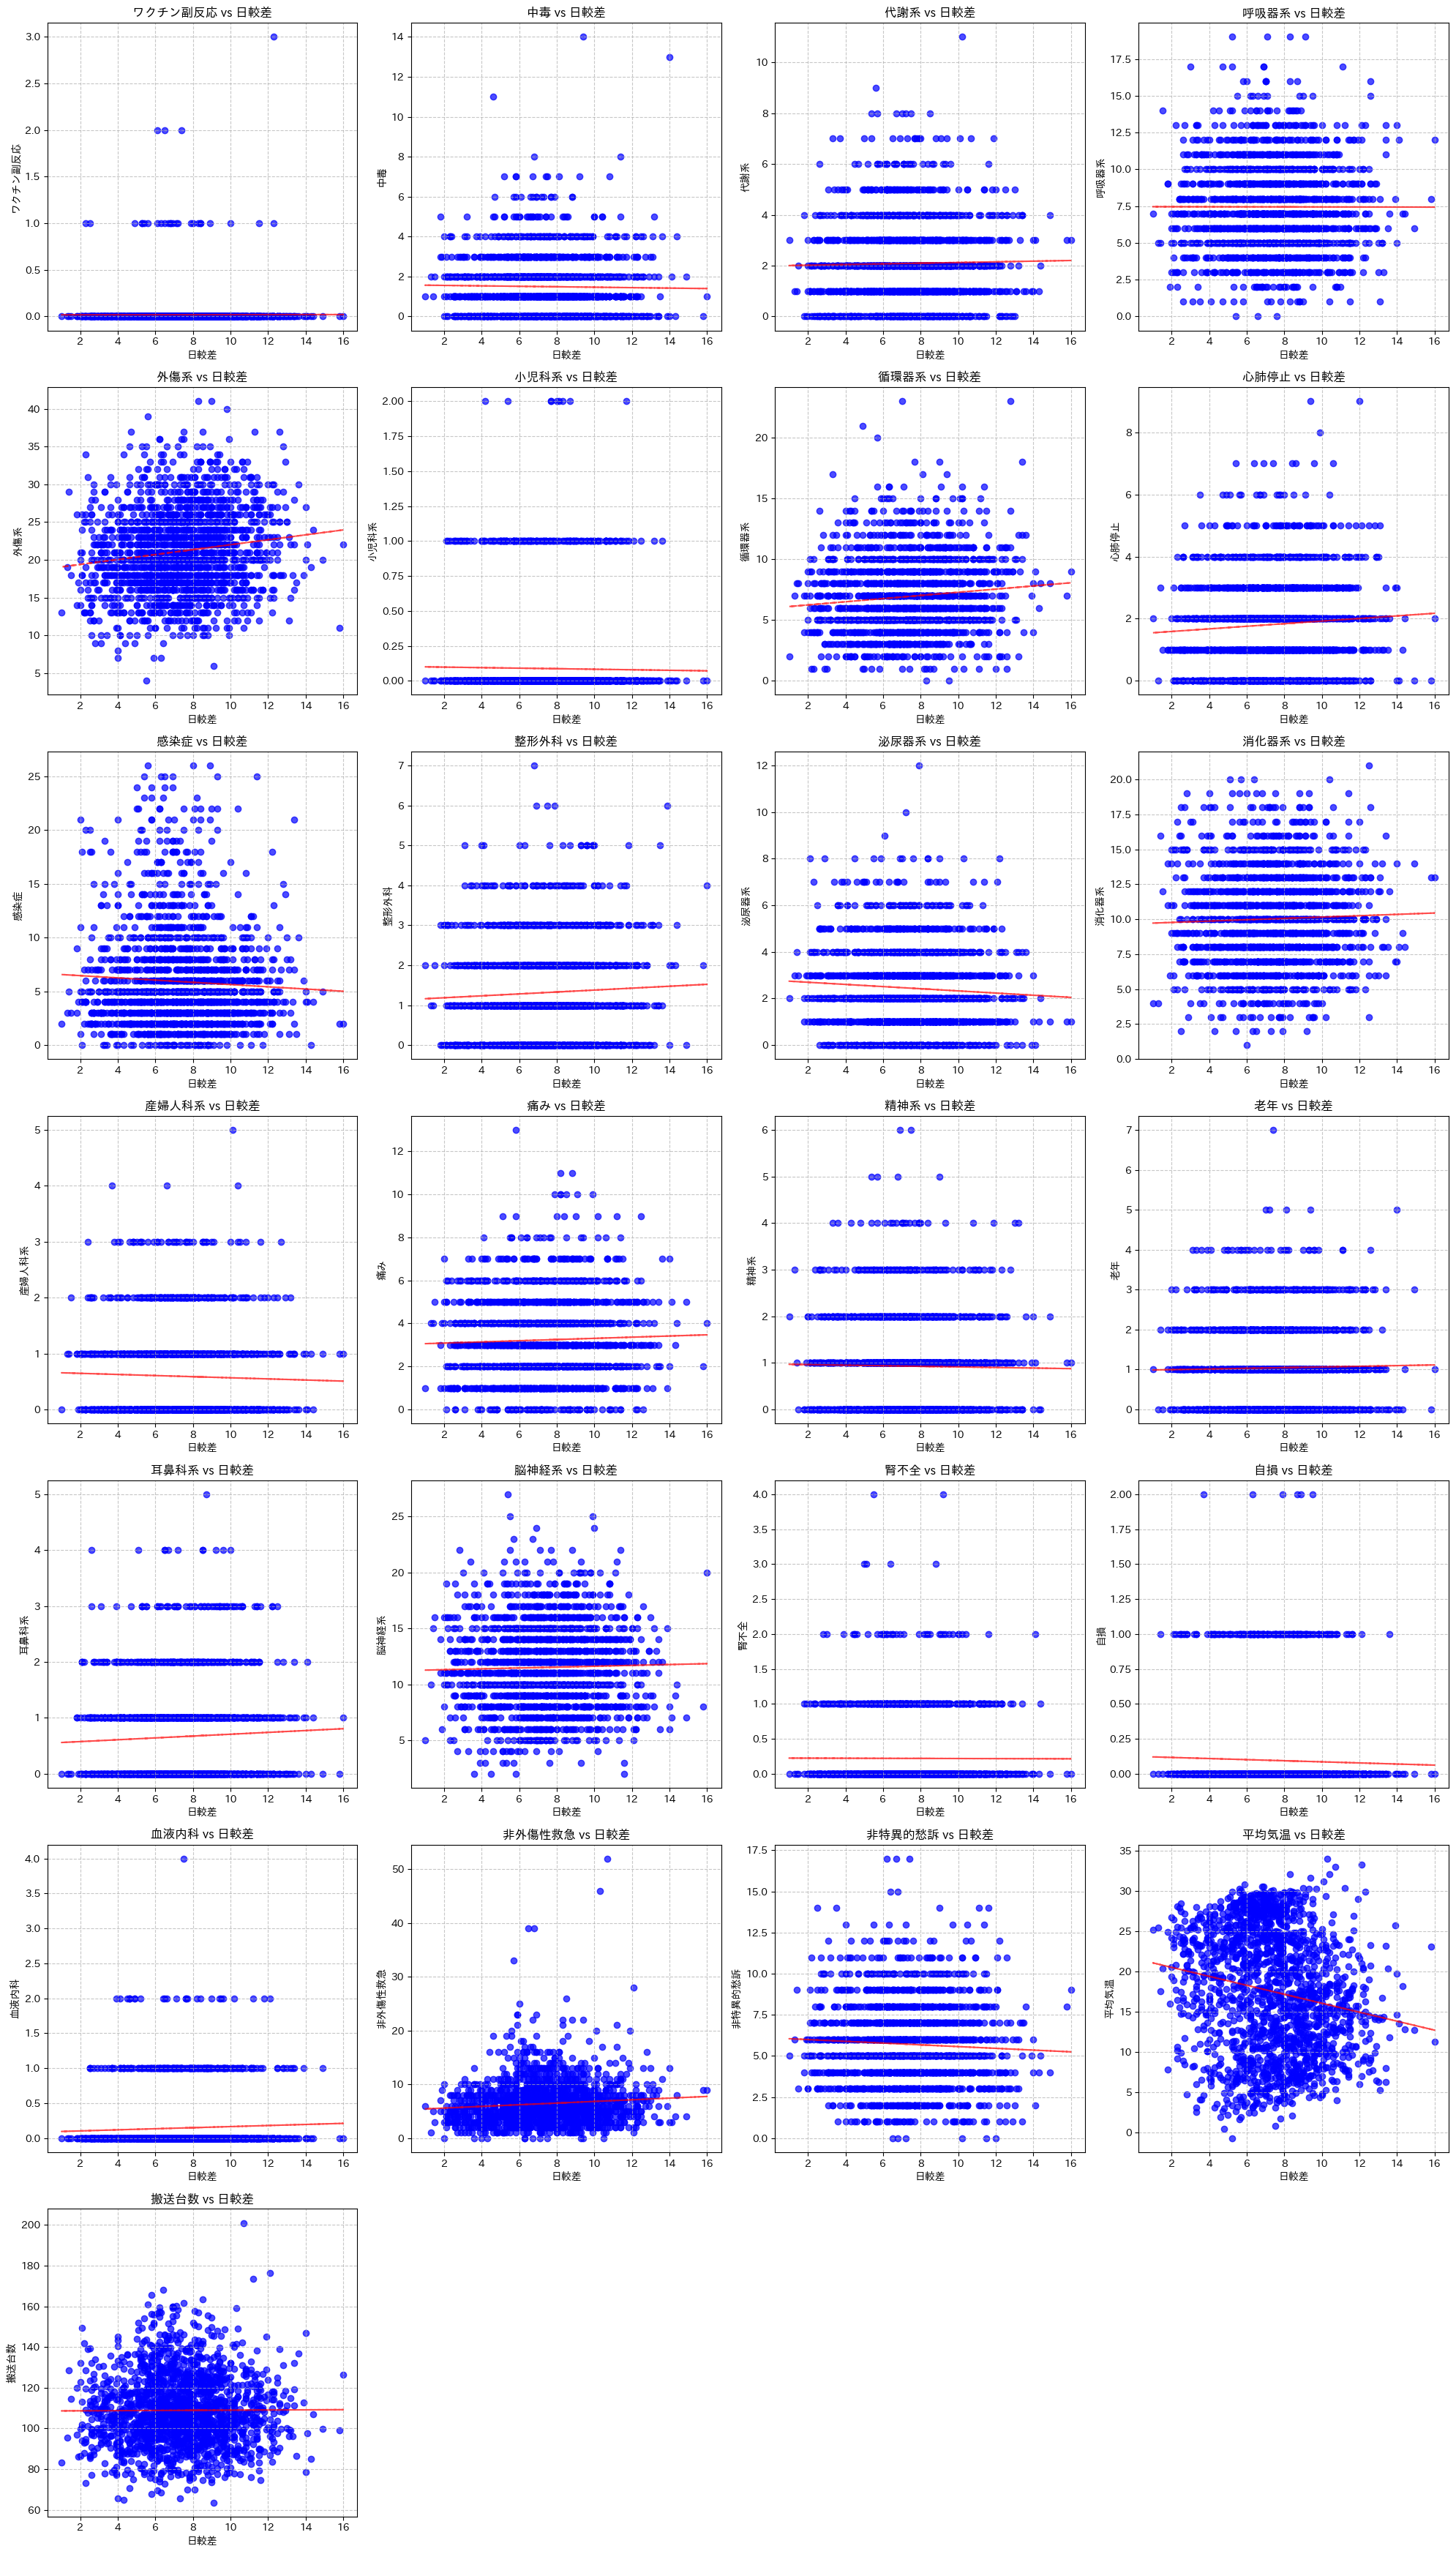

日較差との相関係数と統計的有意性：
       症例区分  ピアソン相関係数     p値  スピアマン相関係数  スピアマンp値
4       外傷系    0.1442 0.0000     0.1442   0.0000
6      循環器系    0.1022 0.0000     0.1097   0.0000
21   非外傷性救急    0.0901 0.0001     0.0839   0.0003
7      心肺停止    0.0701 0.0027     0.0683   0.0035
9      整形外科    0.0490 0.0361     0.0432   0.0650
20     血液内科    0.0466 0.0463     0.0527   0.0244
16     耳鼻科系    0.0465 0.0468     0.0398   0.0890
13       痛み    0.0349 0.1357     0.0312   0.1827
11     消化器系    0.0346 0.1396     0.0440   0.0602
17     脳神経系    0.0248 0.2897     0.0329   0.1604
2       代謝系    0.0199 0.3954     0.0144   0.5376
15       老年    0.0196 0.4029     0.0157   0.5038
24     搬送台数    0.0055 0.8139    -0.0029   0.9028
0   ワクチン副反応    0.0026 0.9123    -0.0161   0.4929
3      呼吸器系   -0.0015 0.9473    -0.0123   0.5995
18      腎不全   -0.0033 0.8880    -0.0039   0.8672
14      精神系   -0.0150 0.5221    -0.0132   0.5725
5      小児科系   -0.0152 0.5157    -0.0191   0.4141
1        中毒   -0.0184 0.4316    -0.0511   0.0289
12

In [88]:
import numpy as np

# 全ての症例区分のカラム（気象データを除く）
categories = df_allinone.columns[1:-4]  # 'timegroup'と気象データカラムを除外

# 症例区分を合計して「搬送台数」列を作成
df_allinone['搬送台数'] = df_allinone[categories].sum(axis=1)

# カテゴリに「搬送台数」を追加
categories = list(categories) + ['搬送台数']

# 複数のサブプロットを作成
n_categories = len(categories)
n_cols = 4  # 1行あたりの図の数
n_rows = (n_categories + n_cols - 1) // n_cols  # 必要な行数を計算

# fig, axの形式でプロット作成
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # 2次元配列を1次元に変換

# 各症例区分ごとに散布図を作成
for i, category in enumerate(categories):
    ax = axes[i]
    
    # 散布図をプロット
    ax.scatter(df_allinone['日較差'], df_allinone[category], color='blue', alpha=0.7)
    
    # 回帰直線を追加（参考として）
    if len(df_allinone) > 1:  # データが2点以上ある場合のみ回帰直線を描画
        z = np.polyfit(df_allinone['日較差'], df_allinone[category], 1)
        p = np.poly1d(z)
        ax.plot(df_allinone['日較差'], p(df_allinone['日較差']), "r--", alpha=0.7)
    
    # タイトルと軸ラベルを設定
    ax.set_title(f'{category} vs 日較差')
    ax.set_xlabel('日較差')
    ax.set_ylabel(category)
    
    # グリッドを追加
    ax.grid(True, linestyle='--', alpha=0.7)

# 余分なサブプロットを非表示にする
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# レイアウトを調整
fig.tight_layout()
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 相関係数とp値を計算して表示
from scipy import stats

correlation_data = []
for category in categories:
    # ピアソン相関係数とp値を計算
    corr, p_value = stats.pearsonr(df_allinone['日較差'], df_allinone[category])
    # スピアマン相関係数も計算（順位相関）
    rho, p_rho = stats.spearmanr(df_allinone['日較差'], df_allinone[category])
    
    correlation_data.append({
        '症例区分': category, 
        'ピアソン相関係数': corr, 
        'p値': p_value,
        'スピアマン相関係数': rho,
        'スピアマンp値': p_rho
    })

correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.sort_values('ピアソン相関係数', ascending=False)

# 小数点以下の桁数を制限して表示
pd.set_option('display.float_format', '{:.4f}'.format)
print("日較差との相関係数と統計的有意性：")
print(correlation_df)

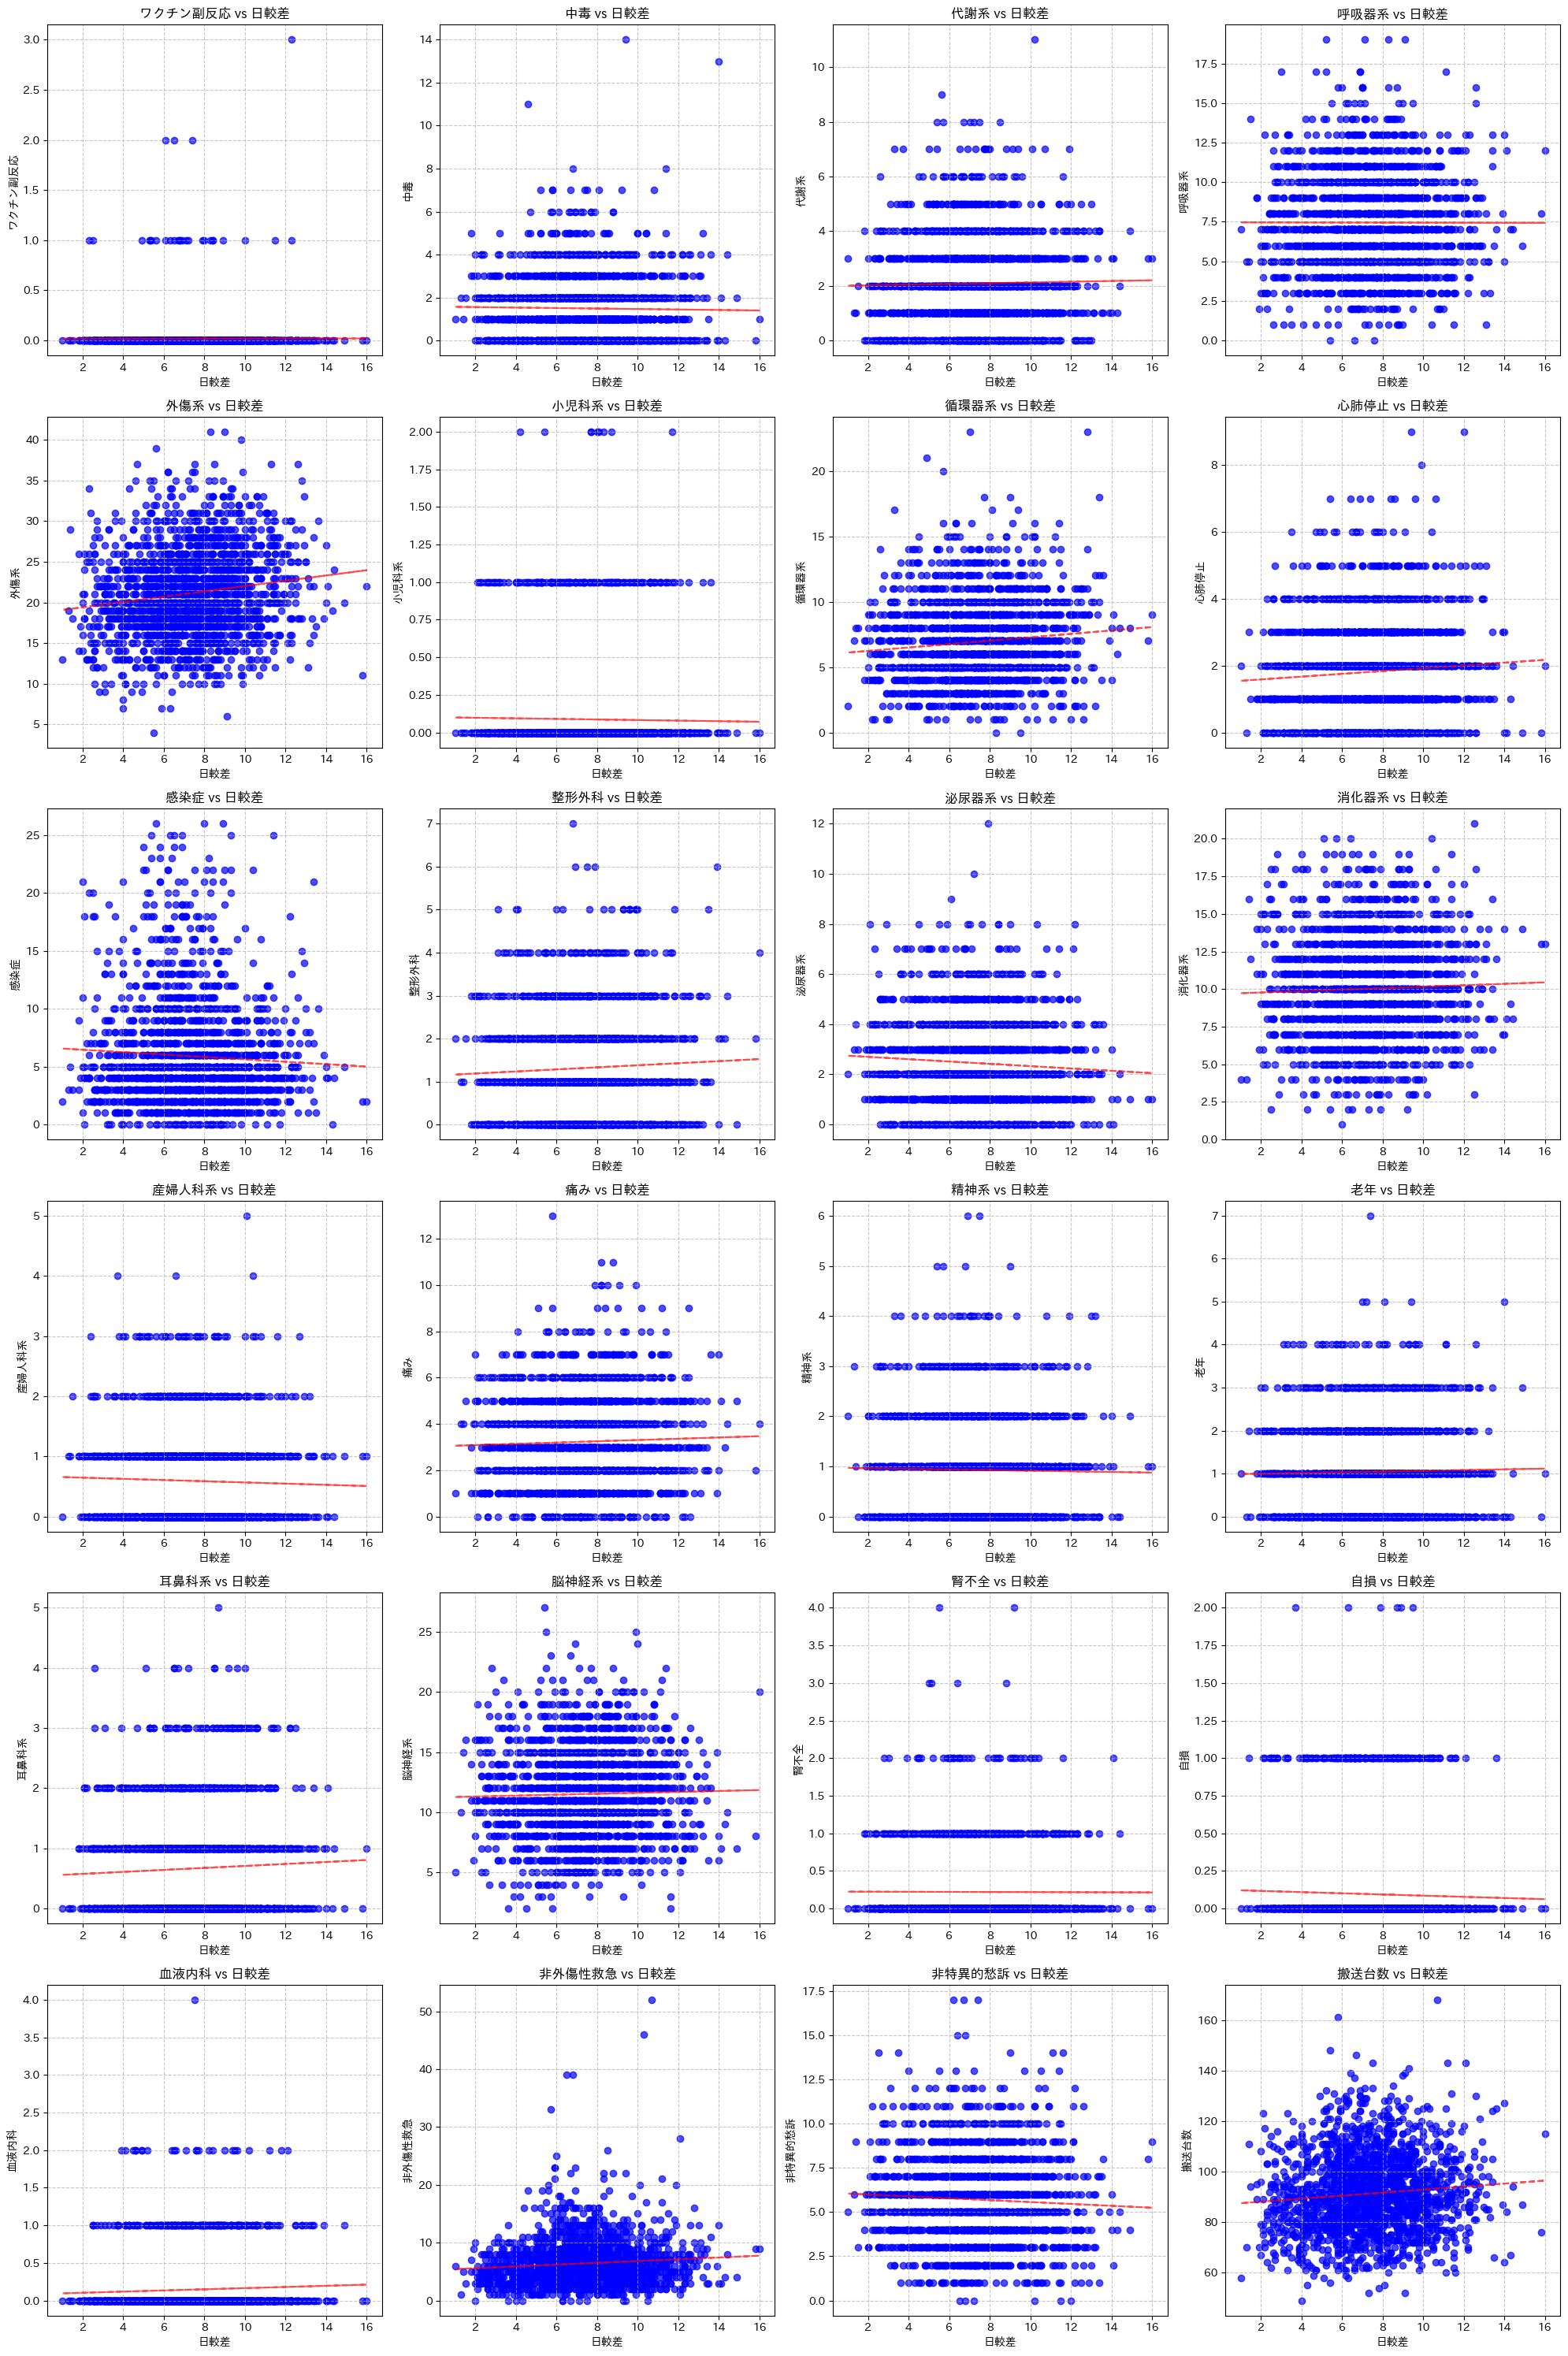

日較差との相関係数：
       症例区分  日較差との相関係数
4       外傷系   0.144228
6      循環器系   0.102168
23     搬送台数   0.090929
21   非外傷性救急   0.090096
7      心肺停止   0.070086
9      整形外科   0.049040
20     血液内科   0.046633
16     耳鼻科系   0.046537
13       痛み   0.034931
11     消化器系   0.034587
17     脳神経系   0.024788
2       代謝系   0.019900
15       老年   0.019587
0   ワクチン副反応   0.002580
3      呼吸器系  -0.001549
18      腎不全  -0.003298
14      精神系  -0.014989
5      小児科系  -0.015222
1        中毒  -0.018417
12    産婦人科系  -0.030884
19       自損  -0.030956
22   非特異的愁訴  -0.050622
8       感染症  -0.053285
10     泌尿器系  -0.065832


In [87]:
import numpy as np

# 全ての症例区分のカラム（気象データを除く）
categories = df_allinone.columns[1:-4]  # 'timegroup'と気象データカラムを除外
# 症例区分を合計して「搬送台数」列を作成
df_allinone['搬送台数'] = df_allinone[categories].sum(axis=1)

# カテゴリに「搬送台数」を追加
categories = list(categories) + ['搬送台数']

# 複数のサブプロットを作成
n_categories = len(categories)
n_cols = 4  # 1行あたりの図の数
n_rows = (n_categories + n_cols - 1) // n_cols  # 必要な行数を計算

# fig, axの形式でプロット作成
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # 2次元配列を1次元に変換

# 各症例区分ごとに散布図を作成
for i, category in enumerate(categories):
    ax = axes[i]
    
    # 散布図をプロット
    ax.scatter(df_allinone['日較差'], df_allinone[category], color='blue', alpha=0.7)
    
    # 回帰直線を追加（参考として）
    if len(df_allinone) > 1:  # データが2点以上ある場合のみ回帰直線を描画
        z = np.polyfit(df_allinone['日較差'], df_allinone[category], 1)
        p = np.poly1d(z)
        ax.plot(df_allinone['日較差'], p(df_allinone['日較差']), "r--", alpha=0.7)
    
    # タイトルと軸ラベルを設定
    ax.set_title(f'{category} vs 日較差')
    ax.set_xlabel('日較差')
    ax.set_ylabel(category)
    
    # グリッドを追加
    ax.grid(True, linestyle='--', alpha=0.7)

# 余分なサブプロットを非表示にする
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# レイアウトを調整
fig.tight_layout()
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 相関係数を計算して表示
correlation_data = []
for category in categories:
    corr = df_allinone[category].corr(df_allinone['日較差'])
    correlation_data.append({'症例区分': category, '日較差との相関係数': corr})

correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.sort_values('日較差との相関係数', ascending=False)
print("日較差との相関係数：")
print(correlation_df)

In [72]:
# 両方のデータフレームのインデックスを確認
df_categorized_daily = aggregate_by_timeframe(df_categolized, timeframe='day')
print("インデックスの型:", type(df_categorized_daily.index[0]), type(result_tenki.index[0]))
print("df_categorized_daily インデックス:", df_categorized_daily.index[:5])
print("result_tenki インデックス:", result_tenki.index[:5])

インデックスの型: <class 'str'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>
df_categorized_daily インデックス: Index(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05'], dtype='object', name='timegroup')
result_tenki インデックス: DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05'],
              dtype='datetime64[ns]', name='date', freq=None)


,平均気温,最高気温,最低気温,その他,ワクチン副反応,中毒,代謝系,呼吸器系,外傷系,小児科系,...,痛み,精神系,老年,耳鼻科系,脳神経系,腎不全,自損,血液内科,非外傷性救急,非特異的愁訴
2019-01-01,6.295652,11.2,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,7.158333,11.1,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,5.975000,10.4,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,6.512500,11.5,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,9.429167,12.6,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,5.0,0.0,1.0,5.0,11.0,29.0,0.0,...,7.0,2.0,0.0,0.0,16.0,0.0,0.0,0.0,9.0,7.0
2023-12-28,NaN,NaN,NaN,4.0,0.0,1.0,4.0,17.0,26.0,0.0,...,1.0,2.0,4.0,0.0,14.0,0.0,0.0,0.0,6.0,7.0
2023-12-29,NaN,NaN,NaN,2.0,0.0,0.0,0.0,7.0,27.0,0.0,...,0.0,0.0,1.0,0.0,13.0,1.0,0.0,0.0,5.0,4.0
2023-12-30,NaN,NaN,NaN,4.0,0.0,4.0,3.0,16.0,37.0,0.0,...,4.0,2.0,4.0,1.0,7.0,0.0,0.0,0.0,13.0,7.0


In [49]:
aggregate_by_timeframe(df_categolized, timeframe='day').dtypes

その他        int64
ワクチン副反応    int64
中毒         int64
代謝系        int64
呼吸器系       int64
外傷系        int64
小児科系       int64
循環器系       int64
心肺停止       int64
感染症        int64
整形外科       int64
泌尿器系       int64
消化器系       int64
産婦人科系      int64
痛み         int64
精神系        int64
老年         int64
耳鼻科系       int64
脳神経系       int64
腎不全        int64
自損         int64
血液内科       int64
非外傷性救急     int64
非特異的愁訴     int64
dtype: object

In [47]:
pd.concat([result,aggregate_by_timeframe(df_categolized, timeframe='day')],axis=1)



,平均気温,最高気温,最低気温,その他,ワクチン副反応,中毒,代謝系,呼吸器系,外傷系,小児科系,...,痛み,精神系,老年,耳鼻科系,脳神経系,腎不全,自損,血液内科,非外傷性救急,非特異的愁訴
2019-01-01,6.295652,11.2,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,7.158333,11.1,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,5.975000,10.4,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,6.512500,11.5,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,9.429167,12.6,7.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,5.0,0.0,1.0,5.0,11.0,29.0,0.0,...,7.0,2.0,0.0,0.0,16.0,0.0,0.0,0.0,9.0,7.0
2023-12-28,NaN,NaN,NaN,4.0,0.0,1.0,4.0,17.0,26.0,0.0,...,1.0,2.0,4.0,0.0,14.0,0.0,0.0,0.0,6.0,7.0
2023-12-29,NaN,NaN,NaN,2.0,0.0,0.0,0.0,7.0,27.0,0.0,...,0.0,0.0,1.0,0.0,13.0,1.0,0.0,0.0,5.0,4.0
2023-12-30,NaN,NaN,NaN,4.0,0.0,4.0,3.0,16.0,37.0,0.0,...,4.0,2.0,4.0,1.0,7.0,0.0,0.0,0.0,13.0,7.0


In [ ]:
aggregate_by_timeframe(df_categolized, timeframe='day')

In [12]:
df_categolized.head(10).to_clipboard()

In [ ]:
weekday_stats

In [ ]:
def calculate_rolling_stats(df, value_column, ax,  window=7):
    """
    移動平均と移動標準偏差を計算する
    
    Parameters:
    df: DataFrame - 入力データ
    value_column: str - 分析対象の列名
    window: int - 移動窓の大きさ（デフォルト：7）
    ax : matplotlib.axes.Axes - プロット先のaxオブジェクト  

    Returns:
    df_stats: pandas.DataFrame - 移動統計量を追加したデータフレーム
    ax: matplotlib.axes.Axes - プロットを含むaxオブジェクト
    """

    # 移動平均と移動標準偏差を計算
    df_stats = df.copy()
    ma = df[value_column].rolling(window=window).mean()
    std = df[value_column].rolling(window=window).std()
    
    # プロット
    df_stats[value_column].plot(ax=ax, style='-', label='実測値', alpha=0.7)
    ma.plot(ax=ax, style='--', label='移動平均', color='red', linewidth=2)
    
    # 標準偏差のレンジをfill_between()で表示
    ax.fill_between(df_stats.index, 
                   ma - std, 
                   ma + std, 
                   alpha=0.2, 
                   color='red',
                   label='±1標準偏差')
    # 軸の最大値・最小値の設定
    ax.set_ylim(50, 170)
    ax.set_title('時系列データと移動平均（±標準偏差）')
    ax.set_xlabel('日付')
    ax.set_ylabel('値')
    ax.grid(True)
    ax.legend()
    
    return df_stats, ax
# 日付ベースで件数カウント
df_datebase = df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()

# figとaxの作成は関数外で行う   
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語対応

year = 2023
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
_, ax = calculate_rolling_stats(df_datebase[f"{year}/1/1":f"{year}/12/31"],"count", ax=ax)
title = ax.get_title()
ax.set_title(title + f"[{year}]")
fig.savefig(f"../output/{year}移動平均.svg", bbox_inches='tight')


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL # STL分解
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,1,1)
df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"].plot(ax=ax)   

In [11]:
# stl分解してみる
stl = STL(df_clean.groupby(pd.Grouper(key="datetime", freq="D")).sum()["count"], period=7)
result = stl.fit()


In [ ]:
result.seasonal

In [ ]:
result.trend

In [ ]:
result.trend.plot()

In [ ]:
result.resid